#NOTEBOOK to convert a SavedModel (EfficinetDet D0) to a TFlite file

#IMORTANT NOTE
## It seems that TFlite conversion code has hard coded the meaning on the output2D array indices (first-index) as you can see in the image below when reading in the TFlite model for EfficientDet D0 there are 8 values to the 1st index and their meanding is defined (unfortuanly unlike python where a dictionary is used in Android-java  an array is used with numbers instead of string keys.   Now there is a break tin tf-nightly that we reported on issues bord that after the version listed below they changed the index order numerically and causes you to either figure out (with no documentation) what this new order should be and alter the corresponding Android code  OR INSTEAD revert to a previous tfnightly version that has the order shown in the Android code below

##Do not change the tf nightly version 
order of tensor output changes with tf nighlt version
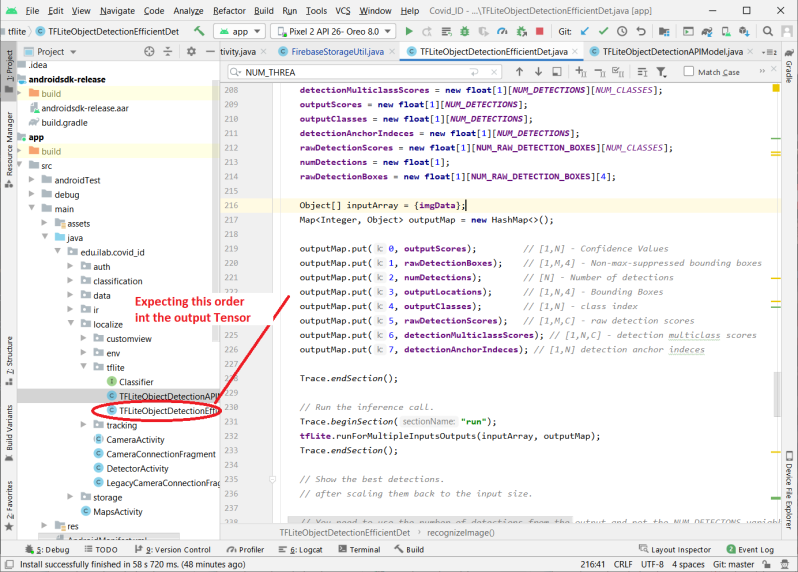see [https://www.tensorflow.org/lite/performance/post_training_quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) for details about TFlite Converter options


In [ ]:
!pip install tf-nightly==2.4.0-dev20200929

     |████████████████████████████████| 391.7MB 34kB/s 
     |████████████████████████████████| 20.1MB 148kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tf-nightly 2.4.0.dev20201019
    Uninstalling tf-nightly-2.4.0.dev20201019:
      Successfully uninstalled tf-nightly-2.4.0.dev20201019


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.__version__

'2.4.0-dev20201019'

In [ ]:
%cd /content/drive/My\ Drive/maskDetection/ 
%ls 'fine_tuned_model/saved_model'
saved_model_dir = 'fine_tuned_model/saved_model'


model = tf.saved_model.load(saved_model_dir)
model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY].inputs[0].set_shape([1, 512, 512, 3])
tf.saved_model.save(model, "saved_model_new", signatures=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY])

/content/drive/My Drive/maskDetection
assets/  saved_model.pb  variables/
INFO:tensorflow:Assets written to: saved_model_new/assets


In [ ]:
# Convert
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir='saved_model_new', signature_keys=['serving_default'])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

In [ ]:
%pwd

'/content/drive/My Drive/maskDetection'

In [ ]:
import numpy as np


## TFLite Interpreter to check input shape
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input and output tensors
print("INPUT DETAILS: \n",input_details)
print("OUTPUT DETAILS: \n",output_details)
# Test the model on random input data.
input_shape = input_details[0]['shape']
print(input_shape)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

INPUT DETAILS: 
 [{'name': 'serving_default_input_tensor:0', 'index': 0, 'shape': array([  1, 512, 512,   3], dtype=int32), 'shape_signature': array([  1, 512, 512,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
OUTPUT DETAILS: 
 [{'name': 'StatefulPartitionedCall:4', 'index': 66563, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([ 1, -1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:6', 'index': 66384, 'shape': array([    1, 49104,     4], dtype=int32), 'shape_signature': array([    1, 49104,     4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0

In [ ]:

tflite_file = '/content/drive/My Drive/maskDetection/fine_tuned_model/maskDetector2.tflite'
#%cd /drive/My\ Drive/Maithri_TF/fine_tuned_model/
%cd /content/drive/My\ Drive/maskDetection/fine_tuned_model/
#now save the tflite model to the file
#tflite_model.save(tflite_file)   #Note this does not seem to work although in google documentation
open(tflite_file, "wb").write(tflite_model)
!ls /content/drive/My\ Drive/maskDetection/fine_tuned_model

/content/drive/My Drive/maskDetection/fine_tuned_model
checkpoint	      maskDetector.tflite  saved_model
maskDetector2.tflite  pipeline.config


In [ ]:
from google.colab import files
#files.download(tflite_model)

!ls /content/drive/My\ Drive/maskDetection/fine_tuned_model

files.download('/content/drive/My Drive/maskDetection/fine_tuned_model/maskDetector2.tflite')

checkpoint	      maskDetector.tflite  saved_model
maskDetector2.tflite  pipeline.config


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import random
import cv2
import glob
import numpy as np
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='/content/drive/My Drive/maskDetection/fine_tuned_model/maskDetector.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


### LOADING IMAGE
'''
def load_grayscale_image_into_numpy_array(path):
  # read in image as grayscale cv2 image
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  # convert image to rgb
  backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
  return backtorgb.astype(np.uint8)
'''
def load_rgb_image_into_numpy_array(path):
  # read in image as grayscale cv2 image
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  
  im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return im_rgb

# download test image
test_image = load_rgb_image_into_numpy_array('/content/drive/My Drive/maskDetection/inference/testImages/0015.jpg')

# RESIZE TO 512 x 512

# set a new height in pixels
new_height = 512
new_width = 512
dsize = (new_width, new_height)
# resize image
scaled_image = cv2.resize(test_image, dsize, interpolation = cv2.INTER_AREA)
# generate tensor
input_tensor = tf.convert_to_tensor(np.expand_dims(scaled_image, 0), dtype=tf.uint8)

print(input_tensor.shape)

interpreter.set_tensor(input_details[0]['index'], input_tensor)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
print("output array length: " + str(len(output_data[0])))

(1, 512, 512, 3)
[[0.9609589  0.0873408  0.06809524 0.05999154 0.05568287 0.03616852
  0.03515935 0.03388214 0.02964088 0.02917778 0.02844885 0.02752271
  0.02532643 0.02329737 0.02278286 0.0213418  0.0210638  0.02019128
  0.01916748 0.01763159 0.01730308 0.0164015  0.01632011 0.01615366
  0.01609802 0.01606014 0.01520342 0.01478559 0.01420614 0.0132328
  0.01292685 0.01276404 0.01265842 0.01264325 0.01245722 0.01230013
  0.01227069 0.01221645 0.01210919 0.01204768 0.01181906 0.01178762
  0.01154467 0.01148716 0.01128137 0.01100454 0.01090339 0.01090035
  0.01056659 0.01046374 0.01039562 0.01035801 0.0101763  0.01016143
  0.01015401 0.0101212  0.00995958 0.00986671 0.00980252 0.00979534
  0.00976944 0.00947464 0.00944296 0.00930616 0.00917202 0.00895733
  0.00894633 0.00891778 0.00886655 0.00885886 0.00849381 0.00849113
  0.00848216 0.00847018 0.00844333 0.00835618 0.00833991 0.00832459
  0.00819856 0.0081273  0.00803497 0.00802234 0.00790223 0.0078285
  0.0078209  0.00782064 0.0077888